In [29]:
import sys
sys.path.append("..")
from src.query_funcs import *
from src.analysis_func import *
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')


In [30]:
df = pd.read_csv("../datos/df_complete.csv", index_col=0)

In [31]:
# df[df["Cantidad"].map(lambda x: round(x, ndigits=2), na_action="ignore") == 0]

In [32]:
# df[(df["Día"] == "2024-10-26")&(df["Subcategoria"].isna())&(df["Supermercado"] == "carrefour")]

#### Conteo de productos por supermercado

In [33]:

conexion = conectar()
result = query_fetch(conexion, query_text='''select s.nombre AS nombre_supermercado,
	c.nombre as nombre_categoria,
    count(distinct p.nombre) as n_productos
from productos p
join supermercado s on p.id_supermercado = s.id_supermercado
join subcategorias sc on sc.id_subcat = p.id_subcat 
join categorias c on c.id_categoria = sc.id_categoria 
group by
    s.nombre, c.nombre
order by 
    n_productos DESC;''')

result_df = pd.DataFrame(result)
result_df.rename(columns=dict(enumerate(["Supermercado", "Categoria", "N de productos"])), inplace=True)
# result_df



In [34]:
px.bar(result_df, x = "Supermercado", y = "N de productos",
        color="Categoria", title ="Conteo de artículos por supermercado",
        color_discrete_sequence=px.colors.qualitative.Vivid)

#### Precios por supermercado (a día de hoy)

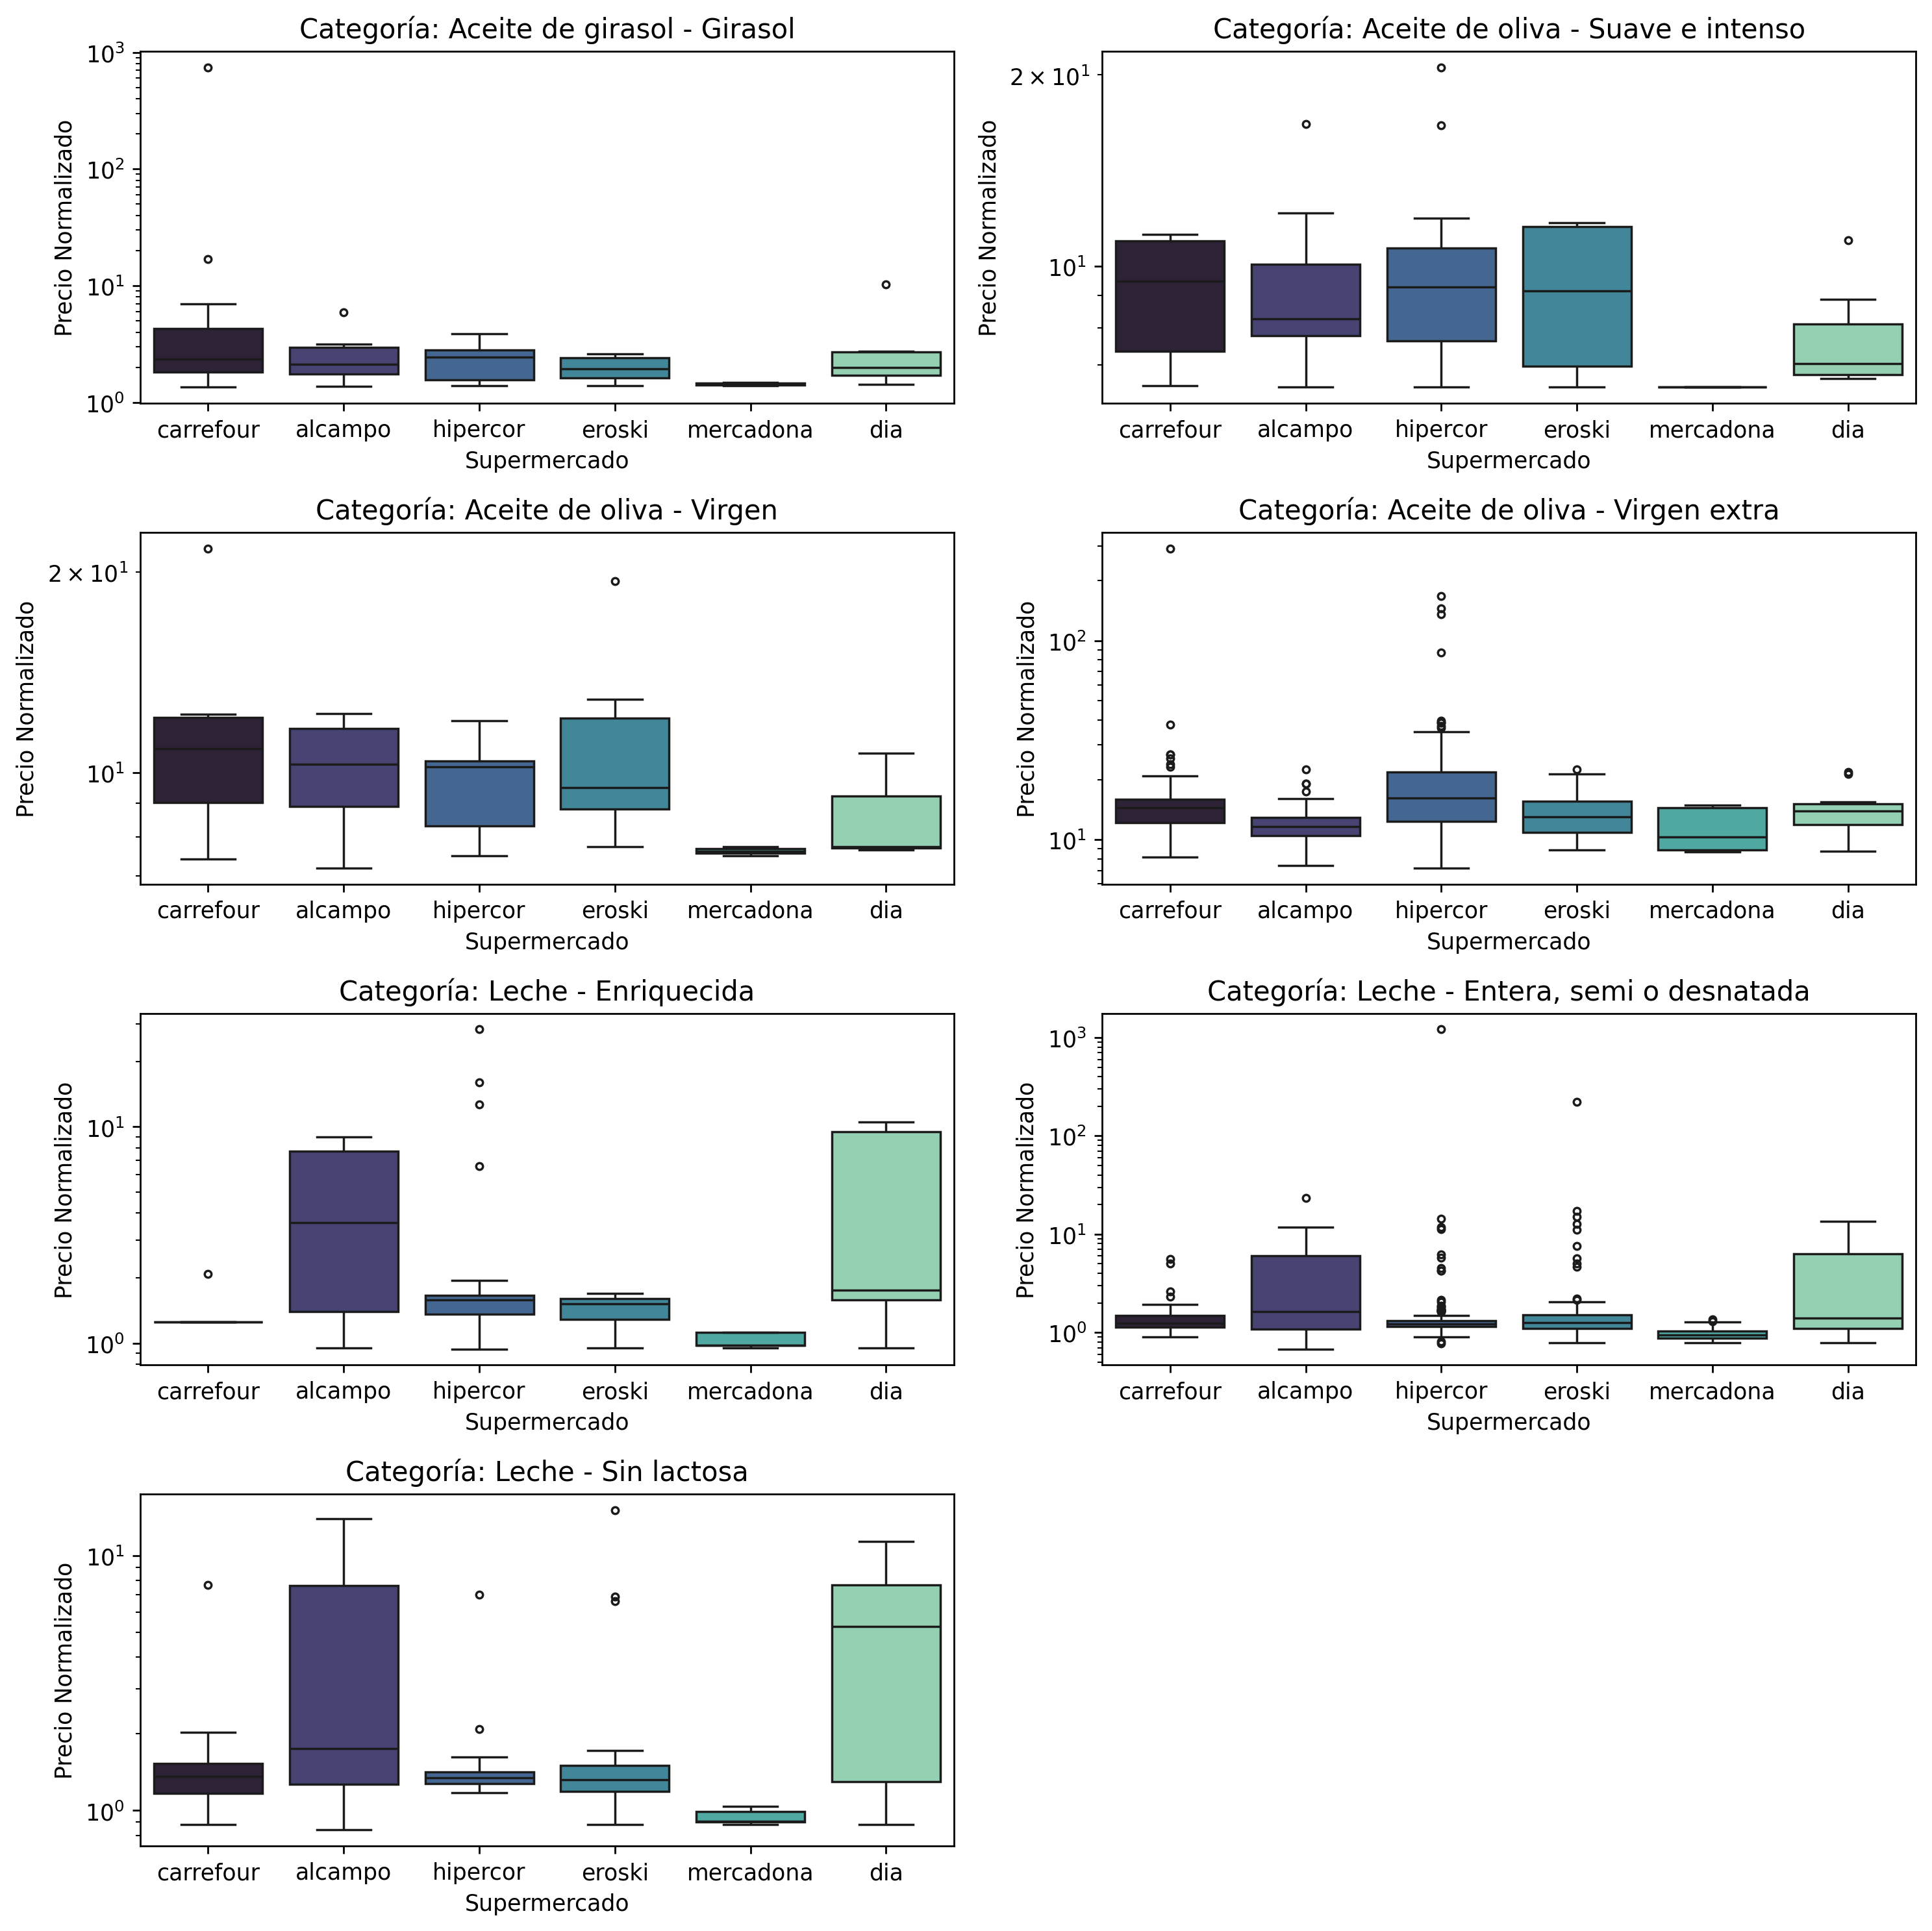

In [35]:
query = '''select 
    p.nombre as nombre_producto, 
    case 
        when p.cantidad is null then null
        when p.unidad = 'g' then (r.precio / p.cantidad) * 1000
        when p.unidad = 'l' THEN r.precio / p.cantidad
        else null
    end as precio_norm,
    c.nombre as categoria,
    s.nombre as subcategoria,
    s2.nombre as nombre_supermercado
from registros r
inner join productos p 
on p.id_producto = r.id_producto
inner join subcategorias s 
on p.id_subcat = s.id_subcat 
inner join categorias c 
on c.id_categoria = s.id_categoria 
inner join supermercado s2 
on s2.id_supermercado = p.id_supermercado 
where r.fecha = '2024-10-26'
order by categoria, subcategoria;''' #! Previamente la query era con 
                                     #!(SELECT MAX(r2.fecha) FROM registros r2), sin embargo,
                                     #! Los domingos hay menos registros, por lo que se impuso una fecha específica

conexion = conectar()
precios_ps = pd.DataFrame(query_fetch(conexion, query), 
                          columns=["nombre_producto", "precio_norm", "categoria", "subcategoria", "supermercado"])

subcategorias = precios_ps["subcategoria"].unique()
supermercados_ordenados = precios_ps["supermercado"].unique() 

fig, axes = plt.subplots(4, 2, figsize=(12, 12), dpi = 250)
axes = axes.flatten()

for i, subcategoria in enumerate(subcategorias):
    df_subcat = precios_ps[precios_ps["subcategoria"] == subcategoria]
    categoria = df_subcat["categoria"].iloc[0] 
    
    sns.boxplot(data=df_subcat, y="precio_norm", x="supermercado", palette="mako", 
                order=supermercados_ordenados, ax=axes[i],  flierprops={"marker": "."})
    
    axes[i].set_title(f"Categoría: {categoria} - {subcategoria}")
    axes[i].set_ylabel("Precio Normalizado")
    axes[i].set_xlabel("Supermercado")
    axes[i].set_yscale("log")
fig.delaxes(axes[7])
    
plt.tight_layout()
plt.show()


In [36]:
precios_ps["precio_norm"] = precios_ps["precio_norm"].astype(float)

In [37]:
precios_ps.iloc[get_outliers_especificos(precios_ps, "carrefour", "Entera, semi o desnatada").index]["nombre_producto"].values

array(['Leche de cabra entera ecológica Cantero de Letur botella 1 l.\n en Carrefour',
       'Leche de cabra semidesnatada Puleva botella 1 l.\n en Carrefour',
       'Leche entera de cabra pasteurizada ecológica Carrefour Bio 750 ml.\n en Carrefour',
       'Leche semidesnatada de oveja Covap brik 1 l.\n en Carrefour'],
      dtype=object)

In [38]:
resultados_min = []

subcategorias = precios_ps["subcategoria"].unique()
for subcategoria in subcategorias:
    df_subcat = precios_ps[precios_ps["subcategoria"] == subcategoria]
    categoria = df_subcat["categoria"].iloc[0]

    for sm in precios_ps["supermercado"].unique():
        minimo = get_min(precios_ps, sm, subcategoria)

        resultados_min.append({
            "categoria": categoria,
            "subcategoria": subcategoria,
            "supermercado": sm,
            "nombre_producto": minimo["nombre_producto"],
            "precio_minimo_norm": minimo["precio_norm"]
        })

df_resultados_min = pd.DataFrame(resultados_min)

ids_min = df_resultados_min.groupby("subcategoria")["precio_minimo_norm"].idxmin()
precios_minimos = df_resultados_min.iloc[ids_min].reset_index(drop=True)
precios_minimos

,categoria,subcategoria,supermercado,nombre_producto,precio_minimo_norm
0,Leche,Enriquecida,hipercor,EL CORTE INGLES leche desnatada sin lactosa en...,0.94
1,Leche,"Entera, semi o desnatada",alcampo,TIERRA DE SABOR Leche entera de vaca 1 l. en A...,0.68
2,Aceite de girasol,Girasol,carrefour,Aceite de girasol para freír Carrefour garrafa...,1.35
3,Leche,Sin lactosa,alcampo,"L.R. Leche desnatada de vaca, sin lactosa 1l. ...",0.84
4,Aceite de oliva,Suave e intenso,alcampo,PRODUCTO ALCAMPO Aceite de oliva suave garrafa...,6.45
5,Aceite de oliva,Virgen,alcampo,COOSUR Aceite de oliva virgen cocina Mediterrá...,7.19
6,Aceite de oliva,Virgen extra,hipercor,EL CORTE INGLES aceite de oliva intenso 1º con...,7.19


In [39]:
precios_minimos["nombre_producto"].values

array(['EL CORTE INGLES leche desnatada sin lactosa enriquecida con vitaminas A, D, E y B9 brik 1 l en Hipercor',
       'TIERRA DE SABOR Leche entera de vaca 1 l. en Alcampo',
       'Aceite de girasol para freír Carrefour garrafa 5 l. en Carrefour',
       'L.R. Leche desnatada de vaca, sin lactosa 1l. en Alcampo',
       'PRODUCTO ALCAMPO Aceite de oliva suave garrafa de 5 l. en Alcampo',
       'COOSUR Aceite de oliva virgen cocina Mediterránea garrafa de 5 l. en Alcampo',
       'EL CORTE INGLES aceite de oliva intenso 1º contiene aceites refinados, vírgenes y 50% de virgen extra garrafa 5 l en Hipercor'],
      dtype=object)

In [40]:
resultados_max = []

subcategorias = precios_ps["subcategoria"].unique()
for subcategoria in subcategorias:
    df_subcat = precios_ps[precios_ps["subcategoria"] == subcategoria]
    categoria = df_subcat["categoria"].iloc[0]

    for sm in precios_ps["supermercado"].unique():
        minimo = get_max(precios_ps, sm, subcategoria)

        resultados_max.append({
            "categoria": categoria,
            "subcategoria": subcategoria,
            "supermercado": sm,
            "nombre_producto": minimo["nombre_producto"],
            "precio_maximo_norm": minimo["precio_norm"]
        })

df_resultados_max = pd.DataFrame(resultados_max)

ids_max = df_resultados_max.groupby("subcategoria")["precio_maximo_norm"].idxmax()
precios_maximos = df_resultados_max.iloc[ids_max].reset_index(drop=True)
precios_maximos


,categoria,subcategoria,supermercado,nombre_producto,precio_maximo_norm
0,Leche,Enriquecida,hipercor,HIPP BIOLOGICO leche de continuación Bio 2 eco...,28.250000
1,Leche,"Entera, semi o desnatada",hipercor,"LARSA leche entera de pastoreo botella 1,5 ml ...",1213.333333
2,Aceite de girasol,Girasol,carrefour,Ozolife Aceite Girasol Ozonizado Air-less 50 M...,740.800000
3,Leche,Sin lactosa,eroski,"Leche semidesnatada sin lactosa PASCUAL, pack ...",15.050000
4,Aceite de oliva,Suave e intenso,hipercor,"CARBONELL aceite de oliva suave 0,4º Original ...",20.550000
5,Aceite de oliva,Virgen,carrefour,Aceite de oliva virgen plancha y horno Carbone...,21.700000
6,Aceite de oliva,Virgen extra,carrefour,Aceite de oliva virgen extra Capricho Andaluz ...,291.000000


In [41]:
precios_maximos["nombre_producto"].values

array(['HIPP BIOLOGICO leche de continuación Bio 2 ecológica con omega 3 y calcio desde los 6 meses envase 600 g en Hipercor',
       'LARSA leche entera de pastoreo botella 1,5 ml en Hipercor',
       'Ozolife Aceite Girasol Ozonizado Air-less 50 Ml en Carrefour',
       'Leche semidesnatada sin lactosa PASCUAL, pack 6x200 ml en Eroski',
       'CARBONELL aceite de oliva suave 0,4º Original para plancha y horno spray 200 ml en Hipercor',
       'Aceite de oliva virgen plancha y horno Carbonell 200 ml. en Carrefour',
       'Aceite de oliva virgen extra Capricho Andaluz pack de 10 porciones de 10 ml. en Carrefour'],
      dtype=object)

#### Variación de precios por categoría, por meses

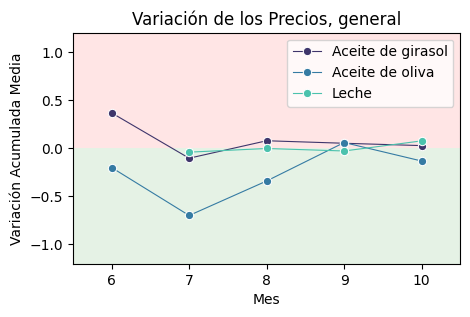

In [42]:
query = '''with variacion_acumulada as(
select extract (month from r.fecha) as mes,
				p.id_producto, s.id_categoria, 
				p.id_supermercado,
				sum(r.var_abs) as variacion_ac
from registros r 
inner join productos p on p.id_producto = r.id_producto 
inner join subcategorias s on s.id_subcat = p.id_subcat
group by mes, p.id_producto, s.id_categoria, p.id_supermercado
order by id_producto
)
select mes, c.nombre, avg(variacion_ac), id_supermercado
from variacion_acumulada va
inner join categorias c on c.id_categoria = va.id_categoria
group by c.nombre, mes, id_supermercado
order by id_supermercado,c.nombre, mes'''

conexion = conectar()
result = pd.DataFrame(query_fetch(conexion, query))
result.rename(columns=dict(enumerate(["mes", "categoria", "variacion_acum_media", "id_supermercado"])), inplace=True)
result["variacion_acum_media"] = result["variacion_acum_media"].apply(lambda x:round(x, ndigits=3))

plt.figure(figsize=(5,3), dpi = 100)
plt.title("Variación de los Precios, general")
sns.lineplot(result, x = "mes", y="variacion_acum_media", hue = "categoria", errorbar=None,
             marker = "o", palette = "mako", lw = 0.8,)
plt.xticks(np.arange(min(result["mes"]), max(result["mes"])+1, 1))
plt.ylabel('Variación Acumulada Media')
plt.xlabel('Mes')
plt.ylim(-1.2,1.2)
plt.xlim(5.5,10.5)
plt.axvspan(xmin = 5, xmax = 11,ymin = -1, ymax=0.5, facecolor = "green", alpha = 0.1)
plt.axvspan(xmin = 5, xmax = 11,ymin = 0.5, ymax=1, facecolor = "red", alpha = 0.1)
plt.legend()
plt.show()

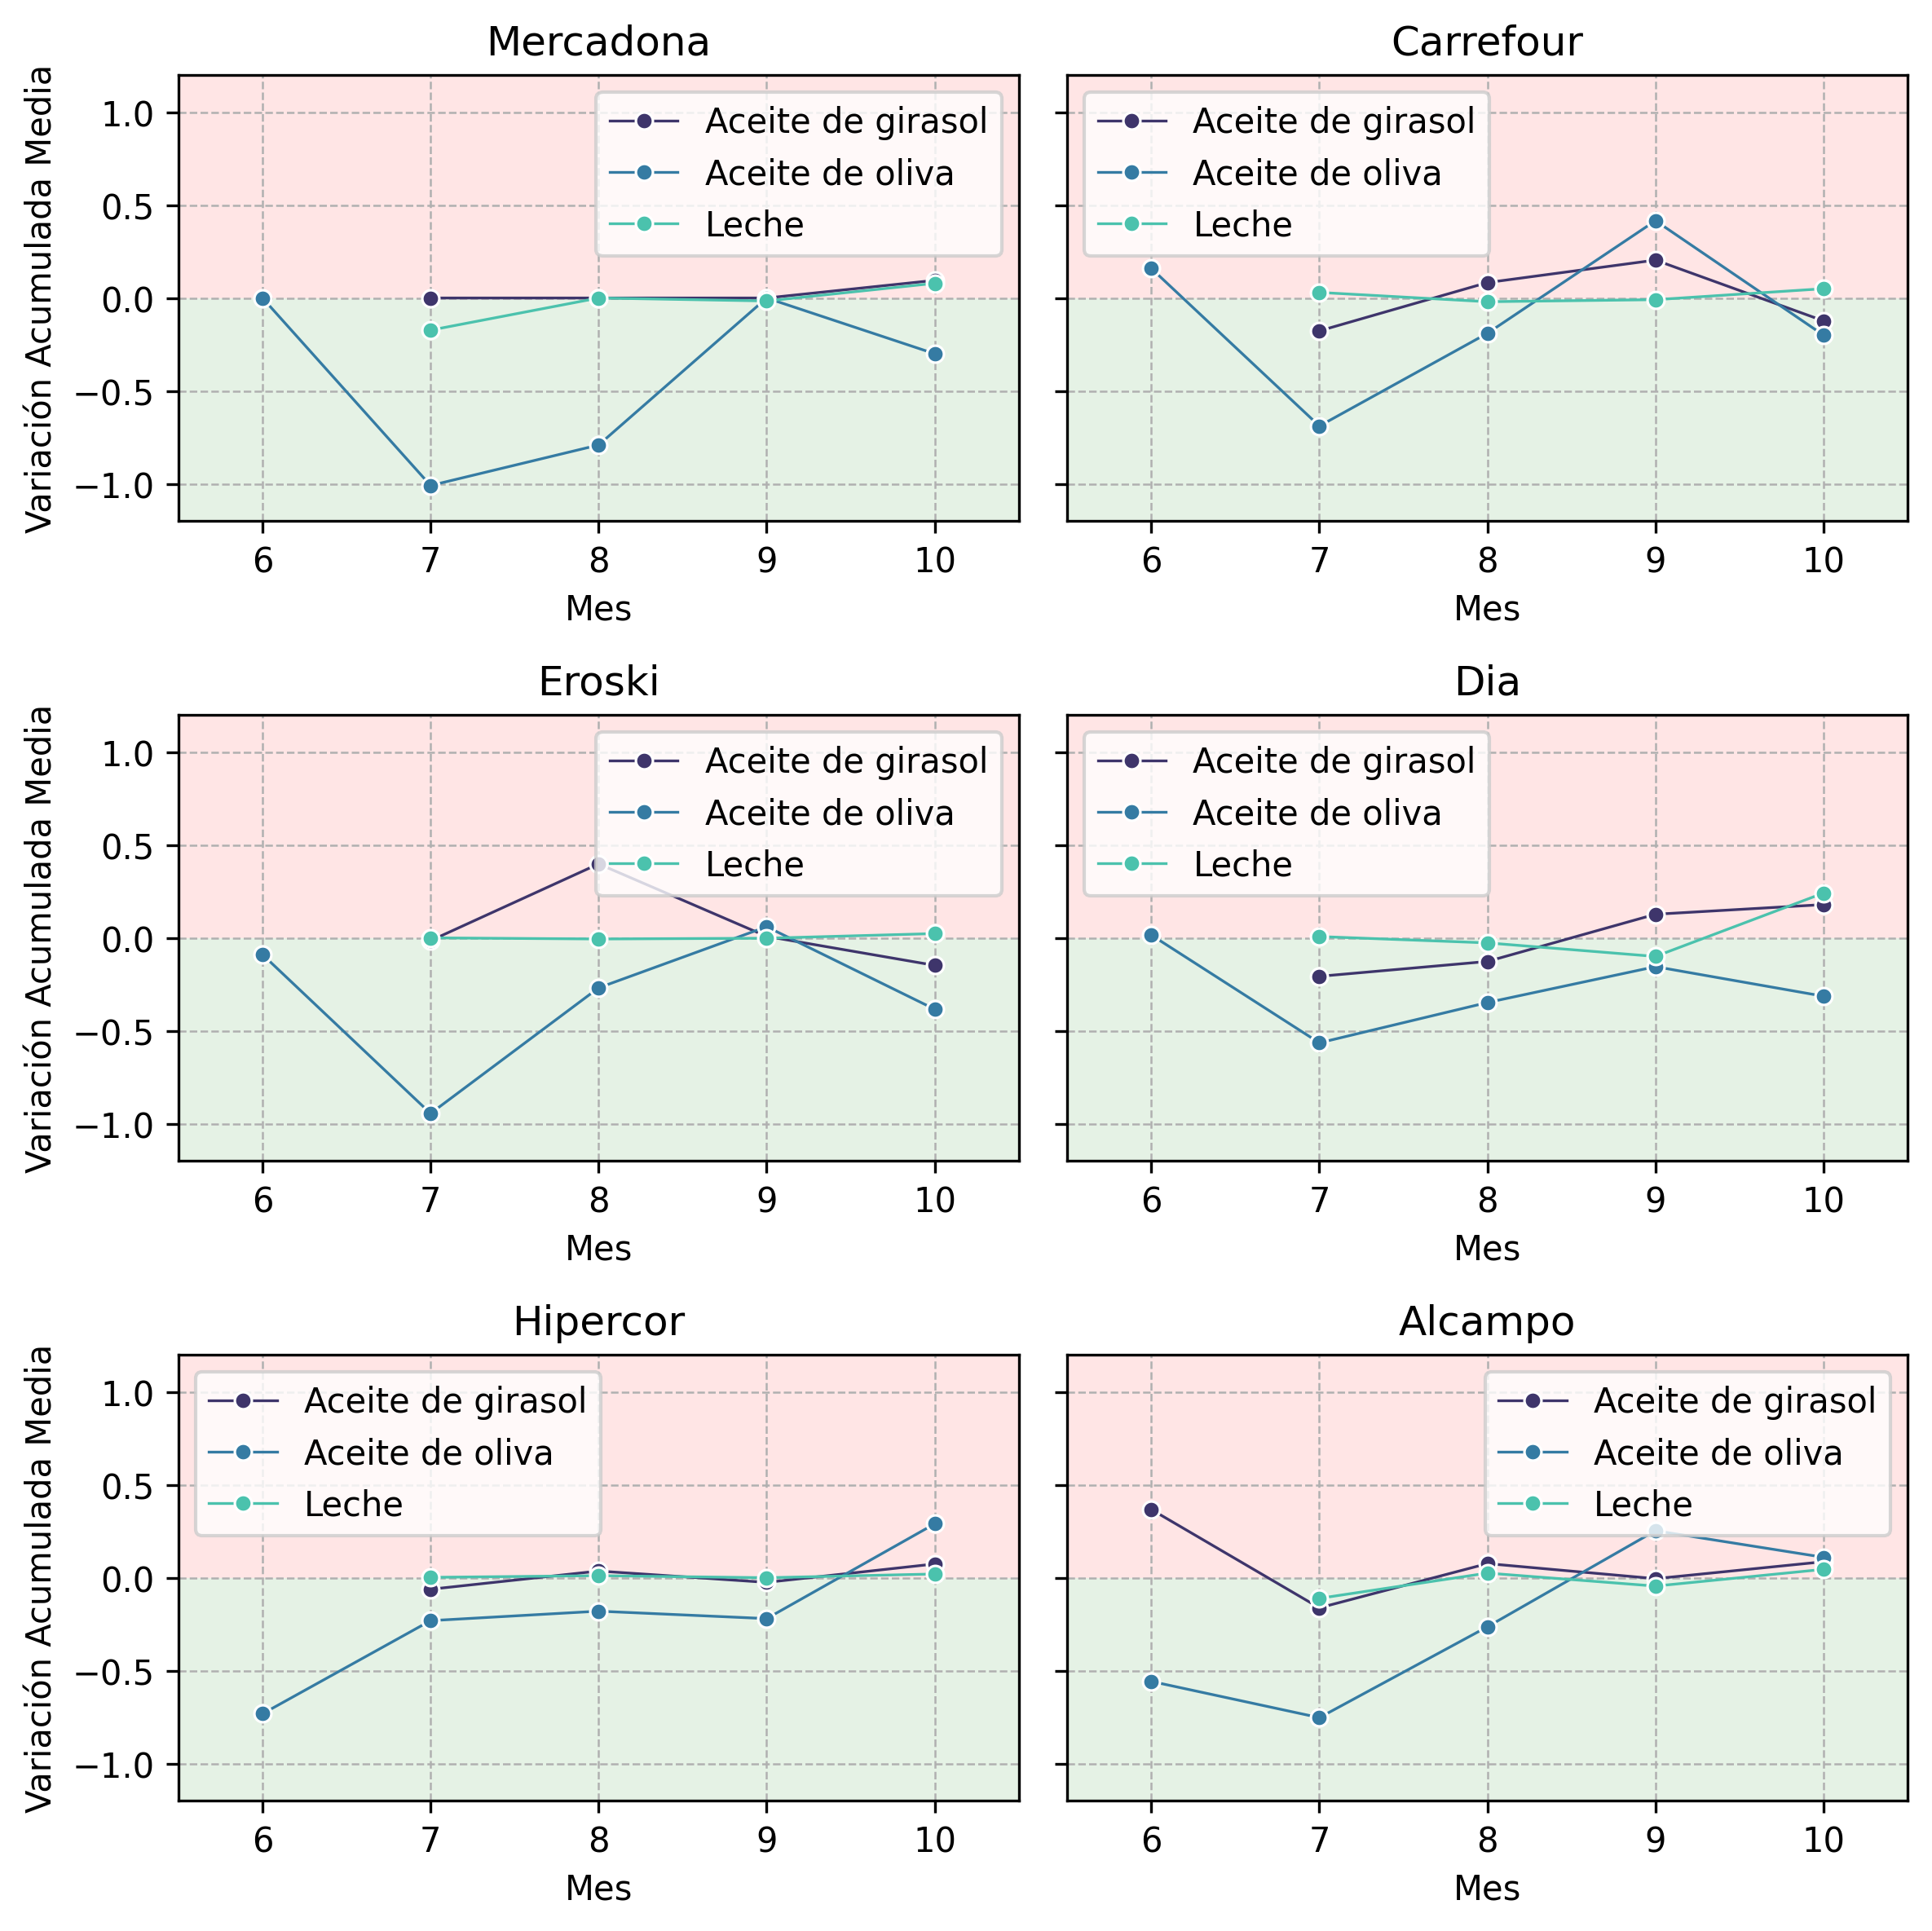

In [43]:
query = '''with variacion_acumulada as(
select extract (month from r.fecha) as mes,
				p.id_producto, s.id_categoria, 
				p.id_supermercado,
				sum(r.var_abs) as variacion_ac
from registros r 
inner join productos p on p.id_producto = r.id_producto 
inner join subcategorias s on s.id_subcat = p.id_subcat
group by mes, p.id_producto, s.id_categoria, p.id_supermercado
order by id_producto
)
select mes, c.nombre, avg(variacion_ac), s.nombre as supermercado
from variacion_acumulada va
inner join categorias c on c.id_categoria = va.id_categoria
inner join supermercado s on va.id_supermercado = s.id_supermercado
group by c.nombre, mes, s.id_supermercado 
order by s.id_supermercado ,c.nombre, mes'''

conexion = conectar()
result = pd.DataFrame(query_fetch(conexion, query))
result.rename(columns=dict(enumerate(["mes", "categoria", "variacion_acum_media", "id_supermercado"])), inplace=True)
result["variacion_acum_media"] = result["variacion_acum_media"].apply(lambda x: round(x, ndigits=3))

supermercados = result['id_supermercado'].unique()


fig, axes = plt.subplots(3, 2, figsize=(8,8), sharey=True, dpi = 300)
axes = axes.flatten()

for i, supermercado in enumerate(supermercados):
    df_supermercado = result[result['id_supermercado'] == supermercado]
    axes[i].grid(lw = 0.6, ls = "--")
    sns.lineplot(data=df_supermercado, x="mes", y="variacion_acum_media", hue="categoria", errorbar=None,
                 marker="o", palette = "mako", lw = 0.8, markersize = 5, ax=axes[i])
    axes[i].axvspan(xmin = 5, xmax = 11,ymin = -1, ymax=0.5, facecolor = "green", alpha = 0.1)
    axes[i].axvspan(xmin = 5, xmax = 11,ymin = 0.5, ymax=1, facecolor = "red", alpha = 0.1)
    axes[i].set_title(f'{supermercado}'.capitalize())
    axes[i].set_ylim(-1.2,1.2)
    axes[i].set_xlim(5.5,10.5)
    axes[i].set_xlabel("Mes")
    axes[i].set_ylabel("Variación Acumulada Media")
    axes[i].legend()

plt.tight_layout()
plt.show()


#### Detección de anomalías